<a href="https://colab.research.google.com/github/Akhil174405/SDG-Classifier/blob/main/SDG1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [2]:
# standard library
from typing import List

# data wrangling
import numpy as np
import pandas as pd

# visualisation
import plotly.express as px
import plotly.io as pio

# nlp
import spacy

# data modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# utils
from tqdm import tqdm

# local packages
from helpers import plot_confusion_matrix, get_top_features, fix_sdg_name

print('Loaded!')

Loaded!


In [3]:
# other settings
pio.templates.default = 'plotly_white'

spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable = ['ner'])


## I. Data Preparation

_In this section, we will explore the data and select texts for training._

In [4]:
df_osdg = pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv?download=1')
print('Shape:', df_osdg.shape)
display(df_osdg.head())

Shape: (32121, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
3,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333
4,10.1787/9789264258211-6-en,0006d6e7593776abbdf4a6f985ea6d95,A region reporting a higher rate will not earn...,3,2,2,0.000000


In [5]:
# calculating cumulative probability over agreement scores
df_lambda = df_osdg['agreement'].value_counts(normalize = True).sort_index().cumsum().to_frame(name = 'p_sum')
df_lambda.reset_index(inplace = True)
df_lambda.rename({'index': 'agreement'}, axis = 1, inplace = True)

print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (36, 2)


,agreement,p_sum
0,0.000000,0.033716
1,0.062432,0.033747
2,0.067982,0.033779
3,0.090909,0.033872
4,0.111111,0.050185


In [6]:
# keeping only the texts whose suggested sdg labels is accepted and the agreement score is at least .6
print('Shape before:', df_osdg.shape)
df_osdg = df_osdg.query('agreement >= .6 and labels_positive > labels_negative').copy()
print('Shape after :', df_osdg.shape)
display(df_osdg.head())

Shape before: (32121, 7)
Shape after : (17233, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000


In [7]:
df_lambda = df_osdg.groupby('sdg', as_index = False).agg(count = ('text_id', 'count'))
df_lambda['share'] = df_lambda['count'].divide(df_lambda['count'].sum()).multiply(100)
print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (15, 3)


,sdg,count,share
0,1,1146,6.650032
1,2,827,4.798932
2,3,1854,10.758429
3,4,2324,13.485754
4,5,2286,13.265247


In [8]:
def preprocess_spacy(alpha: List[str]) -> List[str]:
   
    docs = list()
    
    for doc in tqdm(nlp.pipe(alpha, batch_size = 128)):
        tokens = list()
        for token in doc:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']:
                tokens.append(token.lemma_)
        docs.append(' '.join(tokens))
        
    return docs

In [ ]:
#df_osdg['docs'] = preprocess_spacy(df_osdg['text'].values)
#print('Shape:', df_osdg.shape)
#display(df_osdg.head())

In [ ]:
#df_osdg.to_pickle("preprocess_output.pkl")

Here instead of processing i provided the processed file of the code.



In [9]:
df = pd. read_pickle("preprocess_output.pkl")
print(df.shape)

(17233, 8)


In [ ]:
#df_osdg.shape

In [ ]:
df.dtypes

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['docs'].values, 
    df['sdg'].values, 
    test_size = .3,
    random_state = 42
)

print('Shape train:', X_train.shape)
print('Shape test:', X_test.shape)

Shape train: (12063,)
Shape test: (5170,)


In [12]:
type(X_train)

numpy.ndarray

In [13]:
from sklearn.ensemble import AdaBoostClassifier


In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier#62
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('selector', SelectKBest(f_classif, k = 5_000)),
    ('clf', BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('selector', SelectKBest(k=5000)),
                ('clf',
                 BaggingClassifier(base_estimator=KNeighborsClassifier(),
                                   max_features=0.5, max_samples=0.5))])

In [15]:
y_train

array([ 5,  2,  2, ...,  7, 13,  1])

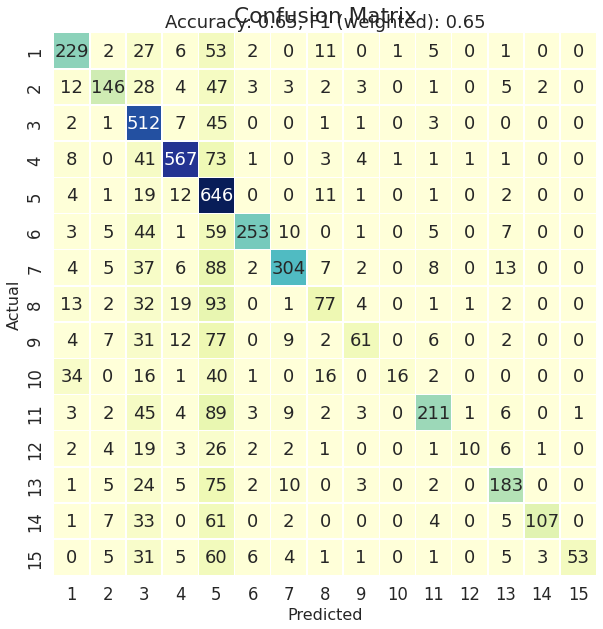

In [16]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

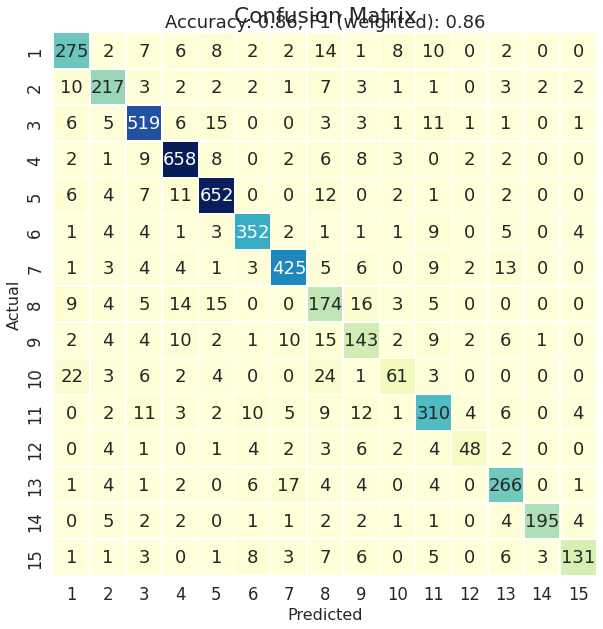

In [17]:
from sklearn.svm import SVC
#Degree: 5 =>33
#Degree: 3 =>66
sega = SVC(kernel='poly',degree=1)
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(ngram_range = (1, 2), max_df = 0.75, min_df = 2, max_features = 100_000)),
    ('selector', SelectKBest(f_classif, k = 1_000)),
    ('clf', sega)
])

pipe.fit(X_train, y_train)
#LEts Try Grid Serch in the  Ski learn
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
temp = pipe.predict([X_test[2]])


In [19]:
print(temp)

[6]


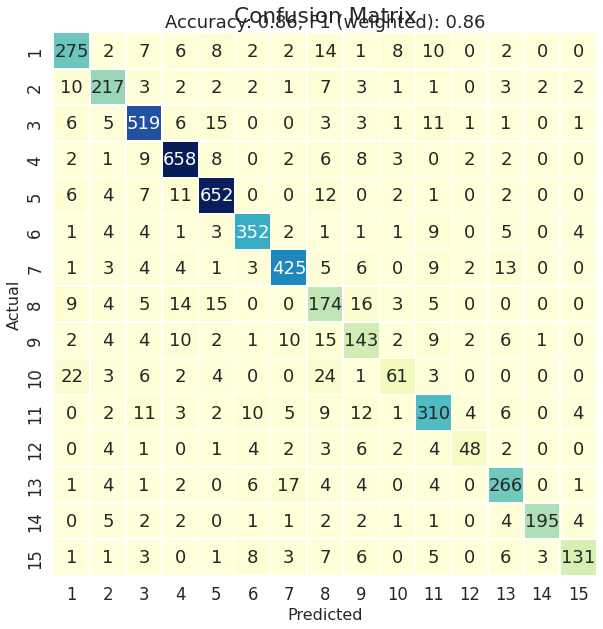

In [20]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {
    'kernel':('linear','poly','rbf','sigmoid'),
    'C':[1,52,10],
    'degree':[3,10],
    'coef0':[0.001,10,0.5],
    'gamma':('auto','scale')
}

In [ ]:
SVModel = SVC()
GridS = GridSearchCV(SVModel,params,cv=5)
#GridS.fit(X_train, y_train)

In [ ]:
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('selector', SelectKBest(f_classif, k = 5_000))
])

In [ ]:
X_test

array(['third option use agricultural withdrawal base charge acreage irrigated land abstraction charge set meaningful level will create incentive utility make efficient use raw water treat wastewater effluent customary levy abstraction charge non - consumptive use fraction rate apply consumptive use precise rate dependent sector location other local circumstance',
       'government active develop use risk mitigant mobilise great sustainable energy investment example can apply other national contexts danish export credit agency particular example institution use guarantee encourage institutional investor participation sustainable energy finance green investment bank other public financial institution work reduce risk provide guarantee loan loss reserve seed fund act cornerstone investor',
       'allow trade urban rural area water market give access water resource user may exclude event drought other word allocation flexibility embed water market allow respond severe supply shock such 

In [ ]:
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(pipe, pickle_out)
pickle_out.close()

In [ ]:
print(X_test[0])

third option use agricultural withdrawal base charge acreage irrigated land abstraction charge set meaningful level will create incentive utility make efficient use raw water treat wastewater effluent customary levy abstraction charge non - consumptive use fraction rate apply consumptive use precise rate dependent sector location other local circumstance
